In [ ]:
# !pip install google-colab
# from google.colab import drive
# drive.mount('/content/gdrive')



In [6]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(device)

cuda


In [8]:
!nvidia-smi

Tue Aug  6 06:23:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   54C    P0              29W /  72W |    601MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set the device
device ='cuda'
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'


# Define the transforms for data preprocessing
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Load the dataset
train_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/horse-or-human/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/horse-or-human/validation', transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
l1, l2 = [], []
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        plt.imshow(x[0][0].cpu().detach().numpy())
        plt.show()
        x = self.pool(nn.functional.relu(self.conv2(x)))
        plt.imshow(x[0][0].cpu().detach().numpy())
        plt.show()
        x = x.view(-1, 16 * 53 * 53)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/(i+1)}')

# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

accuracy = correct / len(test_dataset) * 100
print(f'Test Loss: {test_loss / len(test_loader)}')
print(f'Test Accuracy: {accuracy:.2f}%')

In [32]:
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image


In [29]:
def predict_image(image_path, model):
    image = load_image(image_path).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return preds.item()

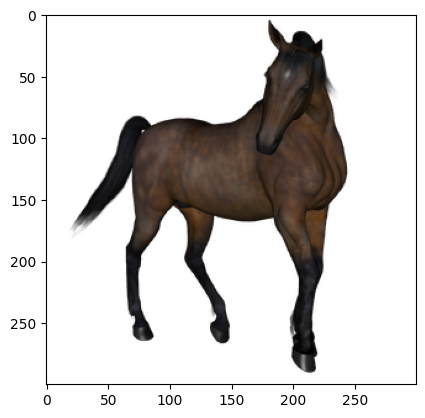

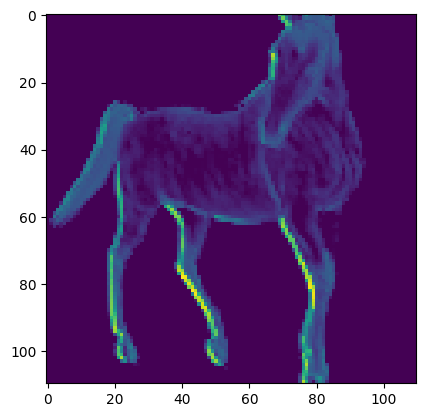

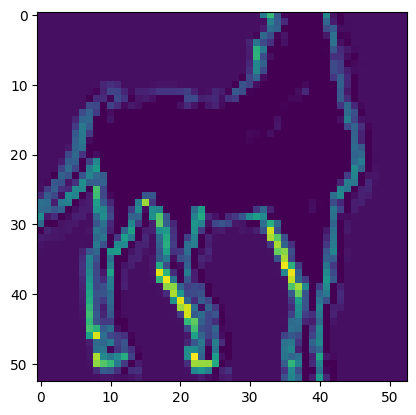

Predicted class: human


In [34]:
class_names = ['human', 'horse']

# Path to the test image
image_path = '/content/gdrive/MyDrive/horse-or-human/validation/horses/horse1-224.png'

# Predict the class
predicted_class = predict_image(image_path, model)
print(f'Predicted class: {class_names[predicted_class]}')